In [1]:
from databaseCommunication import readDatabaseFile, createDataFrame_list
from dataframeFormating import createLabeledDataFrame_list #, N_polarized_pure3b, N_polarized, N_linear, getReducedDataframe, getReducedResults, 
from calculation import trapFrequency, getSubDF
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
from scipy.optimize import curve_fit

In [2]:
label_heads = ['experiment']

#labels = [[[], [151422, 151736]]
#             ] # May 21th

labels = [[[1], [152585, 152650]],
          [[2], [152655, 152672]],
          [[3], [152675, 152692]],
          [[4], [152697, 152738]],
          [[5], [152794, 152875]],
          [[6], [152876, 152920]],
          [[7], [152921, 152967]],
          [[8], [152968, 153000]],
             ] # May 24th
# 1st run: regular decay, long TOF. ODT1 power = 0.73 // ODT2 Power = 0.7 // ODT 3 Power = 0.21
# 2nd run: zoom at long time
# 3rd run: same zoom but with twice the ODT power to check if it's limited by scattering ODT 1 Power = 1.52
#.           ODT2 Power = 1.44 // ODT3 Power = 0.42  
# 4th run: that last power for short time.
# 5th run: hold at 8 times the power : ODT1 = 3.04 0DT2 = 2.88 0DT 3 = 0.84
# 6th run: better coupling, more stable. A couple to exclude at 10000, 200, 5000, 6000
# 7th and 8th run: more dummies
excluded = [152881, 152918, 152919, 152920, 152969, 152932, 152992]

In [3]:
"""ciceroVariables = ['BECHoldTime', 'TOF', 'compz_rotation']
fitVariables = ['nCount', 'xWidth', 'yWidth']

df = createLabeledDataFrame_list(labels, label_heads, ciceroVariables, fitVariables)
for column in df.columns:
    try:
        df[column] = df[column].astype(float)
    except:
        pass
df.to_pickle('data_save_ODT_210524.pickle')"""

"ciceroVariables = ['BECHoldTime', 'TOF', 'compz_rotation']\nfitVariables = ['nCount', 'xWidth', 'yWidth']\n\ndf = createLabeledDataFrame_list(labels, label_heads, ciceroVariables, fitVariables)\nfor column in df.columns:\n    try:\n        df[column] = df[column].astype(float)\n    except:\n        pass\ndf.to_pickle('data_save_ODT_210524.pickle')"

In [4]:
df = pd.read_pickle('data_save_ODT_210524.pickle')
df.rename(columns = {'compz_rotation' : 'compz'}, inplace = True)
indexNames = pd.Index(np.where(df['imageID'].isin(excluded))[0])
df.drop(indexNames, inplace = True)
#df = df[df['BECHoldTime'] < 400]
df_alpha = pd.concat([getSubDF(df, ['experiment'], [2]), getSubDF(df, ['experiment'], [3])])
df_3b = df[df['experiment'] >= 6]
#df_alpha = df_alpha[df_alpha['BECHoldTime'] > 1400]
# Delete these row indexes from dataFrame

In [5]:
BECHoldTimeList = np.sort(df['BECHoldTime'].unique())
compzList = np.sort(df['compz'].unique())
colors = ['red', 'blue', 'orange', 'black', 'green']

In [8]:
BECHoldTimeList
compz = 3.5

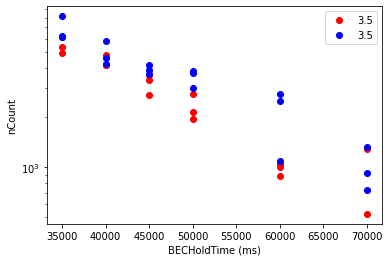

In [11]:
plt.figure()
i = 0
for exp in [2,3]:
    df_temp = getSubDF(df, ['experiment'], [exp])
    plt.semilogy(df_temp['BECHoldTime'], df_temp['nCount'], 'o', color = colors[i], label = str(compz))
    i += 1
plt.legend()
#plt.ylim(0,25000)
plt.xlabel('BECHoldTime (ms)')
plt.ylabel('nCount')
plt.show()

In [12]:
def N_polarized(t, N0, alpha, gamma):
    return np.sqrt(alpha / (np.exp(2*alpha*t)*(alpha/(N0**2)+gamma)-gamma))

def N_linear(t, N0, b):
    return N0-b*t

def N_polarized_pure3b(t, N0, gamma):
    return N0 / np.sqrt(1+N0**2*gamma*t)

def N_1b(t, N0, alpha):
    return N0*np.exp(-alpha*t)

def N_polarized_alpha(t, N0, gamma):
    global alpha
    return np.sqrt(alpha / (np.exp(2*alpha*t)*(alpha/(N0**2)+gamma)-gamma))


def fitRun(df_run):
    N0_guess = max(df_run['nCount'])
    time_guess = max(df_run['BECHoldTime'])
    alpha_guess = 1/time_guess
    gamma_guess = 1/(N0_guess**2*time_guess)
    popt, pcov = curve_fit(N_polarized, df_run['BECHoldTime'], df_run['nCount'],
                       p0 = [N0_guess, alpha_guess, gamma_guess],
                          )#bounds = ((N0_guess/10, alpha_guess/10, gamma_guess/100), (N0_guess*10, alpha_guess*10, gamma_guess*100)),
                           #method = 'trf'
                      #)
    return popt, pcov

def fitRun_pure(df_run):
    N0_guess = max(df_run['nCount'])
    time_guess = max(df_run['BECHoldTime'])
    popt, pcov = curve_fit(N_polarized_pure3b, df_run['BECHoldTime'], df_run['nCount'],
                       p0 = [N0_guess, 1/(N0_guess**2*time_guess)],
                          )#bounds = ((0, 0), (np.inf, np.inf)),
                           #method = 'trf'
                      #)
    return popt, pcov

def fitRun_lin(df_run):
    N0_guess = max(df_run['nCount'])
    time_guess = max(df_run['BECHoldTime'])
    popt, pcov = curve_fit(N_linear, df_run['BECHoldTime'], df_run['nCount'],
                       p0 = [N0_guess, N0_guess/time_guess],
                          )#bounds = ((0, 0), (np.inf, np.inf)),
                           #method = 'trf'
                      #)
    return popt, pcov

def fitRun_pure_alpha(df_run):
    N0_guess = max(df_run['nCount'])
    time_guess = max(df_run['BECHoldTime'])
    gamma_guess = 1/(N0_guess**2*time_guess)
    popt, pcov = curve_fit(N_polarized_alpha, df_run['BECHoldTime'], df_run['nCount'],
                       p0 = [N0_guess, gamma_guess],
                          )#bounds = ((N0_guess/10, alpha_guess/10, gamma_guess/100), (N0_guess*10, alpha_guess*10, gamma_guess*100)),
                           #method = 'trf'
                      #)
    return popt, pcov

In [13]:
compz = 3.5

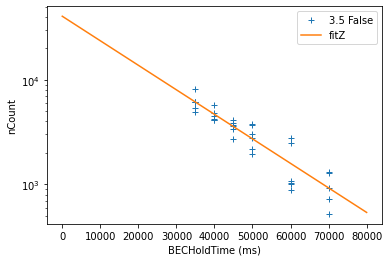

In [14]:
popt, pcov = curve_fit(N_1b, df_alpha['BECHoldTime'], df_alpha['nCount'], p0 = [df_alpha['nCount'].max(), 1/df_alpha['BECHoldTime'].max()])
N0, alpha = popt

time_long = np.linspace(0, 80000, 10000)
Z = N_1b(time_long, N0, alpha)
df_tempZ = getSubDF(df_alpha, ['compz'], [compz])

plt.figure()
plt.semilogy(df_tempZ['BECHoldTime'], df_tempZ['nCount'], '+', label = str(compz) + ' ' + str(False))
plt.semilogy(time_long, Z, '-', label = 'fitZ')
plt.legend()
#plt.ylim(0, 20000)
#plt.xlim(0,10)
plt.xlabel('BECHoldTime (ms)')
plt.ylabel('nCount')
plt.show()

In [15]:
print("This fixes the value of alpha to " + str(round(alpha, 6)))

This fixes the value of alpha to 5.4e-05


In [19]:
1/(alpha*1000)

18.526621524281442

In [20]:
df = df_3b
results = []
results_pure = []
results_lin = []
results_pure_alpha = []


for compz in compzList:
    df_run = getSubDF(df, ['compz'], [compz])
    if not df_run.empty:
        popt, pcov = fitRun(df_run)
        results += [{'N0' : popt[0],
                    'alpha' : min(-10**(-10), popt[1]),
                    'gamma' : popt[2],
                     'compz' : compz
                    }]
resultsDF = pd.DataFrame(results)

for compz in compzList:
    df_run = getSubDF(df, ['compz'], [compz])
    if not df_run.empty:
        popt, pcov = fitRun_pure(df_run)
        results_pure += [{'N0' : popt[0],
                        'alpha' : 0,
                         'gamma' : popt[1],
                          'compz' : compz
                    }]
resultsDF_pure = pd.DataFrame(results_pure)

for compz in compzList:
    df_run = getSubDF(df, ['compz'], [compz])
    if not df_run.empty:
        popt, pcov = fitRun_lin(df_run)
        results_lin += [{'N0' : popt[0],
                         'b' : popt[1],
                         'compz' : compz
                    }]
resultsDF_lin = pd.DataFrame(results_lin)

for compz in compzList:
    df_run = getSubDF(df, ['compz'], [compz])
    if not df_run.empty:
        popt, pcov = fitRun_pure_alpha(df_run)
        results_pure_alpha += [{'N0' : popt[0],
                    'alpha' : alpha,
                    'gamma' : popt[1],
                     'compz' : compz
                    }]
resultsDF_pure_alpha = pd.DataFrame(results_pure_alpha)

In [21]:
popt, pcov = fitRun_pure_alpha(df_run)
np.sqrt(pcov[1, 1])

4.016747451327265e-15

In [22]:
resultsDF_pure_alpha

,N0,alpha,gamma,compz
0,32592.356005,0.000054,2.954880e-15,3.5


In [23]:
df_tempZ = getSubDF(df, ['compz'], [compz])
time = np.linspace(0, 10000, 10000)

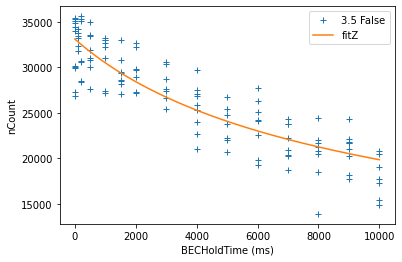

In [24]:
resultZ = getSubDF(resultsDF_pure, ['compz'], [compz])

NZ, alphaZ, gammaZ = resultZ.iloc[0, 1], resultZ.iloc[0, 2], resultZ.iloc[0, 3]
Z = N_polarized_pure3b(time, NZ, gammaZ)

plt.figure()
plt.plot(df_tempZ['BECHoldTime'], df_tempZ['nCount'], '+', label = str(compz) + ' ' + str(False))
plt.plot(time, Z, '-', label = 'fitZ')
plt.legend()
#plt.ylim(0, 20000)
#plt.xlim(0,10)
plt.xlabel('BECHoldTime (ms)')
plt.ylabel('nCount')
plt.show()

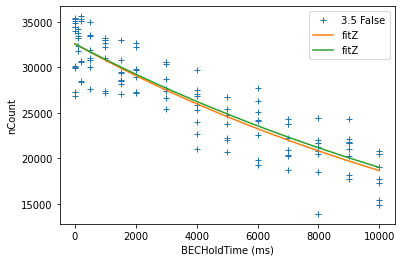

In [26]:
resultZ = getSubDF(resultsDF_pure_alpha, ['compz'], [compz])

NZ, gammaZ = resultZ.iloc[0, 1], resultZ.iloc[0, 3]

Z = N_polarized_alpha(time, NZ, gammaZ)
Z2 = N_1b(time, NZ, alpha)


plt.figure()
plt.plot(df_tempZ['BECHoldTime'], df_tempZ['nCount'], '+', label = str(compz) + ' ' + str(False))
plt.plot(time, Z, '-', label = 'fitZ')
plt.plot(time, Z2, '-', label = 'fitZ')
plt.legend()
#plt.ylim(0,20000)
#plt.xlim(0,10)
plt.xlabel('BECHoldTime (ms)')
plt.ylabel('nCount')
plt.show()

Let's use only the pure 3b fit

In [27]:
#results = resultsDF_pure
results = resultsDF_pure_alpha

In [28]:
m = 164*1.67*10**(-27)
k_B = 1.38*10**(-23)
hbar = 6.626*10**(-34)/(2*np.pi)
sigma_0 = 4

df['temperature'] = (m/k_B*(df['yWidth']**2-sigma_0**2)*(10**(-12))/(df['TOF']**2*10**(-6)))/(10**(-9)) # in nano kelvin
#df['temperature'] = (m/k_B*(df['xWidth']**2-sigma_0**2)*(10**(-12))/(df['TOF']**2*10**(-6)))/(10**(-9)) # in nano kelvin

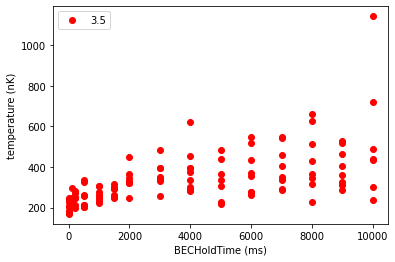

In [29]:
plt.figure()
i = 0
for compz in compzList:
    df_temp = getSubDF(df, ['compz'], [compz])
    plt.plot(df_temp['BECHoldTime'], df_temp['temperature'], 'o', color = colors[i], label = str(compz))
    i += 1
plt.legend()
#plt.xlim(0,300)
#plt.ylim(0,150)
plt.xlabel('BECHoldTime (ms)')
plt.ylabel('temperature (nK)')
plt.show()

In [30]:
df_temperature = df[df['BECHoldTime'] == 0].groupby('compz').mean()*10**(-9)
results['temperature'] = df_temperature['temperature'].tolist()
results

,N0,alpha,gamma,compz,temperature
0,32592.356005,0.000054,2.954880e-15,3.5,2.050876e-07


### Density measurement based on temperature and trap frequency

In the BEC the density is like $n(x, y, z) = K e^{-\frac{\frac{1}{2}m(\omega_x^2 x^2 + \omega_y^2 y^2 + \omega_z^2 z^2)}{k_B T}} = N\omega_x\omega_y\omega_z\left(\frac{m}{2\pi k_B T}\right)^{3/2} e^{-\frac{\frac{1}{2}m(\omega_x^2 x^2 + \omega_y^2 y^2 + \omega_z^2 z^2)}{k_B T}} = n_0 e^{-\frac{\frac{1}{2}m(\omega_x^2 x^2 + \omega_y^2 y^2 + \omega_z^2 z^2)}{k_B T}}$

In [31]:
omega_x = 2*np.pi*220
omega_y = 2*np.pi*90
omega_z = 2*np.pi*220

omega_x = 2*np.pi*70*np.sqrt(8)
omega_y = 2*np.pi*28*np.sqrt(8)
omega_z = 2*np.pi*50*np.sqrt(8)
prefactor = omega_x*omega_y*omega_z*(m/(2*np.pi*k_B))**(3/2)

results['density'] = results['N0']*prefactor/(results['temperature'])**(3/2)*10**(-6)  # in atoms / cm3

By definition $<n^2> = \int n^2p(x, y, z)d\tau = \frac{1}{N}\int n^3 d\tau = N^2 (\omega_x\omega_y\omega_z)^2\frac{1}{\sqrt{27}}\left(\frac{m}{2\pi k_B T}\right)^3 = \frac{N^2}{\sqrt{27}(2\pi)^3(\sigma_x\sigma_y\sigma_z)^2}$. The differential equation formula is: $\frac{dN}{dt} = -\gamma N^3$ in the fit, but $\frac{dN}{dt} = -\beta <n^2> N$ in reality, so $\frac{dN}{dt} = -\beta \frac{N^2}{\alpha} N$ with $\alpha = 3^{3/2}\left(\frac{2\pi k_B T}{m}\right)^3\frac{1}{(\omega_x\omega_y\omega_z)^2} = 3^{3/2}(2\pi)^3(\sigma_x\sigma_y\sigma_z)^2 = \frac{3^{3/2}}{(n_0/N)^2}$, so $\beta = \gamma\alpha$

In [32]:
results['beta'] = results['gamma']*10**3*3**(3/2)/(results['density']/results['N0'])**2 # this is is cm^6/s

In [33]:
results

,N0,alpha,gamma,compz,temperature,density,beta
0,32592.356005,0.000054,2.954880e-15,3.5,2.050876e-07,3.426567e+13,1.389104e-29


### Density measurement based on in situ imaging

Other way to calculate the volume, simply use the in situ imaging with the density being $N/V \simeq N/(2a_x 2a_y 2a_z)^2) = \frac{N}{8(7\mu m 7.3\mu m 18\mu m)}$. Actually more precise calculation gives: $n = \frac{N}{(2\pi)^{3/2}\sigma_x\sigma_y\sigma_z}e^{-\frac{1}{2}(\frac{x^2}{\sigma_x^2}+\frac{y^2}{\sigma_y^2}+\frac{z^2}{\sigma_z^2})}$ and therefore $<n^2> = \frac{1}{N}\int n^3 d\tau = \frac{N^2}{3^{3/2}(2\pi)^3(\sigma_x\sigma_y\sigma_z)^2}$.

In [219]:
sigma_x = 7.1*10**(-4) # in cm
sigma_y = 18*10**(-4) # in cm
sigma_z = 7.3*10**(-4) # in cm

sigma_x = 3.62*10**(-4) # in cm
sigma_y = 9.57*10**(-4) # in cm
sigma_z = 3.62*(6.1/5.2)*10**(-4) # in cm


results['densityVolume'] = results['N0']/((2*np.pi)**(3/2)*sigma_x*sigma_y*sigma_z)  # in atoms / cm3
results['betaVolume'] = results['gamma']*10**3*(3**(3/2))/(results['densityVolume']/results['N0'])**2  # in atoms / cm3

In [220]:
results
# You should only trust the initial 1.9 measurement, the other cloud could have changed size
# (although I checked with 7.72 and this one looks similar)

,N0,alpha,gamma,compz,temperature,density,beta,densityVolume,betaVolume
0,32441.595232,0.000054,3.419598e-15,3.5,2.025893e-07,2.968958e+13,2.121549e-29,1.400157e+13,9.539106e-29


### Check consistency of the 2 approaches

In [221]:
T = results['temperature'][0]  # Take the temperature of the coldest orginial cloud at 1.9
sigma_x_test = np.sqrt(k_B*T/(m*omega_x**2))
sigma_y_test = np.sqrt(k_B*T/(m*omega_y**2))
sigma_z_test = np.sqrt(k_B*T/(m*omega_z**2))

print("The measured sigma_x is " + str(round(sigma_x*10**4, 1)) + " um and the calculated one is " + str(round(sigma_x_test*10**6, 1)) + " um")
print("The measured sigma_y is " + str(round(sigma_y*10**4, 1)) + " um and the calculated one is " + str(round(sigma_y_test*10**6, 1)) + " um")
print("The measured sigma_z is " + str(round(sigma_z*10**4, 1)) + " um and the calculated one is " + str(round(sigma_z_test*10**6, 1)) + " um")

The measured sigma_x is 3.6 um and the calculated one is 2.6 um
The measured sigma_y is 9.6 um and the calculated one is 6.4 um
The measured sigma_z is 4.2 um and the calculated one is 3.6 um


### End

In [37]:
import numpy as np
m = 164*1.67*10**(-27)
k_B = 1.38*10**(-23)
hbar = 6.626*10**(-34)/(2*np.pi)
sigma_0 = 4
T = 200*10**(-9)
omega_x = 2*np.pi*28
np.sqrt(k_B*T/(m*omega_x**2))

1.8044152203236358e-05

In [38]:
np.sqrt(k_B*T/(m*omega_x**2))*(0.105/5)**(1/4)

6.868965030561809e-06